In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import warnings
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')

from data_loading.tools import reduce_mem_usage

In [76]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")
data_path = os.path.join(cache_path, "aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset/versions/1")

if not os.path.exists(data_path):
    # Download latest version
    data_path = kagglehub.dataset_download("aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset")

data = pd.read_csv(os.path.join(data_path, "NF-UQ-NIDS-v2.csv"), nrows=200_000)

data = reduce_mem_usage(data)
data.head()

Memory usage after optimization is: 33.76 MB
Decreased by 51.9%


,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,0,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2


In [77]:
# Data Preprocessing
def preprocess_data(df):
    """Preprocess the network traffic data"""
    # 1. Handle IP addresses - convert to numerical representation
    # In this simplified example, we'll drop them, but in practice you might:
    # - Extract features like subnet, is_private, etc.
    # - Use IP reputation features
    # - Convert to embedding representation
    ip_cols = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
    
    # 2. Identify categorical and numerical columns
    categorical_cols = ['PROTOCOL']  # Add other categorical columns if needed
    
    # Exclude target variables and IP addresses
    exclude_cols = ip_cols + ['Label', 'Attack', 'Dataset']
    numerical_cols = [col for col in df.columns if col not in categorical_cols + exclude_cols]
    
    # 3. Create new features
    df['bytes_ratio'] = df['IN_BYTES'] / (df['OUT_BYTES'] + 1)  # Avoid division by zero
    df['pkts_ratio'] = df['IN_PKTS'] / (df['OUT_PKTS'] + 1)
    df['bytes_per_pkt_in'] = df['IN_BYTES'] / (df['IN_PKTS'] + 1)
    df['bytes_per_pkt_out'] = df['OUT_BYTES'] / (df['OUT_PKTS'] + 1)
    
    # These new features should be added to numerical_cols
    new_features = ['bytes_ratio', 'pkts_ratio', 'bytes_per_pkt_in', 'bytes_per_pkt_out']
    numerical_cols.extend(new_features)
    
    # 4. Create feature matrix X and target vector y
    # For binary classification
    y_binary = df['Label']
    
    # For attack type classification (only on malicious records)
    attack_encoder = LabelEncoder()
    df['Attack_encoded'] = attack_encoder.fit_transform(df['Attack'])
    y_attack = df['Attack_encoded']
    attack_classes = attack_encoder.classes_
    
    # Define preprocessing steps for categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])
    
    # Create X by selecting only the feature columns
    X = df[numerical_cols + categorical_cols]
    
    return X, y_binary, y_attack, attack_classes, preprocessor, attack_encoder

In [78]:
# Preprocess the data
X, y_binary, y_attack, attack_classes, preprocessor, attack_encoder = preprocess_data(data)

# Split the data into training and testing sets
X_train, X_test, y_binary_train, y_binary_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

print(f"Binary classification - Training set: {X_train.shape}, Test set: {X_test.shape}")

Binary classification - Training set: (160000, 45), Test set: (40000, 45)


In [79]:
from sklearn.preprocessing import FunctionTransformer

# Create a safe log transformer that handles zeros and negative values
def safe_log(X):
    # Handle negative values by taking log of absolute and preserving sign
    # Add small constant to avoid log(0)
    sign = np.sign(X)
    log_abs = np.log1p(np.abs(X))  # log(1+|x|)
    return sign * log_abs

log_transformer = FunctionTransformer(safe_log)

# Apply to your data
X_train_log = log_transformer.transform(X_train)
X_test_log = log_transformer.transform(X_test)

# Now your model should work
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
classifier.fit(X_train_log, y_binary_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [80]:
# Check for infinities or NaNs
print(f"Infinity values in X_train: {np.isinf(X_train).sum()}")
print(f"NaN values in X_train: {np.isnan(X_train).sum()}")

# Find the maximum values in each feature
print(f"Max values: {np.max(X_train, axis=0)}")

Infinity values in X_train: L4_SRC_PORT                    0
L4_DST_PORT                    0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128_TO_256_BYTES      0
NUM_PKTS_256_TO

Binary classification accuracy: 0.989225
Binary classification ROC AUC: 0.9985114236027296
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13153
           1       0.99      0.99      0.99     26847

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



Text(0.5, 36.72222222222221, 'Predicted')

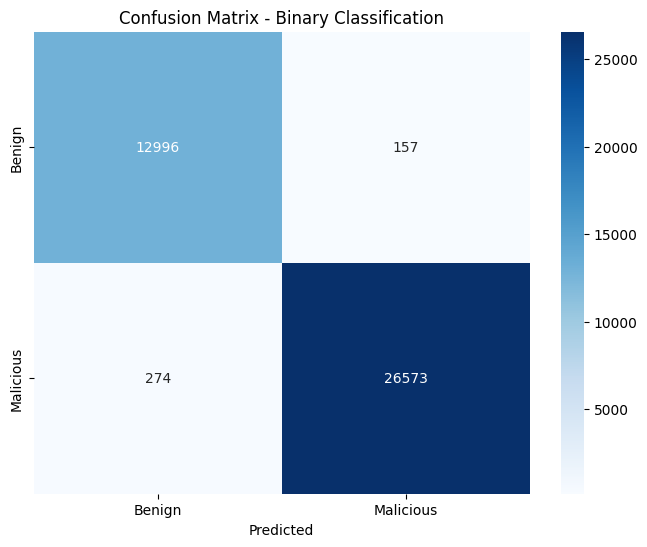

In [81]:
y_binary_pred = classifier.predict(X_test_log)
y_binary_proba = classifier.predict_proba(X_test_log)[:, 1]
print(f"Binary classification accuracy: {accuracy_score(y_binary_test, y_binary_pred)}")
print(f"Binary classification ROC AUC: {roc_auc_score(y_binary_test, y_binary_proba)}")
print(classification_report(y_binary_test, y_binary_pred))
cm = confusion_matrix(y_binary_test, y_binary_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix - Binary Classification')
plt.xlabel('Predicted')

In [86]:
import joblib
joblib.dump(classifier, "binary_classifier.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [47]:
class AttackClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.3):
        super(AttackClassifier, self).__init__()
        
        # Initial feature processing
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # First block with residual connection
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Residual connection adapter if dimensions don't match
        self.residual_adapter = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()
        
        # Self-attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Feature interaction block
        self.interaction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU()
        )
        
        # Final classification layers
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        # Initial normalization
        x_normalized = self.input_bn(x)
        
        # First block with residual connection
        block1_out = self.block1(x_normalized) + self.residual_adapter(x_normalized)
        
        # Self-attention - reshaping for attention mechanism
        # Reshape to (batch_size, sequence_length=1, hidden_dim)
        attention_in = block1_out.unsqueeze(1)
        attention_out, _ = self.attention(attention_in, attention_in, attention_in)
        attention_out = attention_out.squeeze(1)  # Back to original shape
        
        # Add & norm (residual connection around attention)
        combined = self.layer_norm(block1_out + attention_out)
        
        # Feature interaction
        interaction_out = self.interaction(combined) + combined  # Another residual connection
        
        # Classification
        return self.classifier(interaction_out)

scaler = MinMaxScaler()
cols_to_scale = ['FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'OUT_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_OUT_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT', 'SRC_TO_DST_AVG_THROUGHPUT', 'FLOW_DURATION_MILLISECONDS']
scaled_data = data.copy()
cols_to_drop = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'Dataset']
scaled_data.drop(cols_to_drop,axis=1,inplace=True)
scaled_data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])
scaled_data["Label"] = data["Label"]
scaled_data["Attack"] = data["Attack"]

y_attack = scaled_data["Attack"]
X = scaled_data.drop(columns=["Label", "Attack"])
# Handle class imbalance using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y_attack)

X_train, X_test, y_attack_train, y_attack_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [51]:
class NetworkTrafficDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [52]:
scaled_data = scaled_data[scaled_data["Label"] != 0] # only keep attack data
X, y = scaled_data.drop(columns=["Attack", "Label"]), scaled_data["Attack"]
# Encode labels
label_encoder = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_encoder)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_encoded.to_numpy(), test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
trainDataset = NetworkTrafficDataset(X_train, y_train)
valDataset = NetworkTrafficDataset(X_val, y_val)
testDataset = NetworkTrafficDataset(X_test, y_test)
train_dataloader = DataLoader(trainDataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = DataLoader(valDataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(testDataset,batch_size=32,shuffle=True, drop_last=True)

In [62]:
model = AttackClassifier(input_dim=scaled_data.shape[1]-2, hidden_dim=256, num_classes=len(label_encoder))
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-5)

In [58]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_attack_classifier.pt')
    
    return model, history

def evaluate_model(model, test_loader, criterion, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    test_loss = 0.0
    test_correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = test_correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    return all_preds, all_labels

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=50, device=device)

Epoch [1/50] - Train Loss: 0.7438, Train Acc: 0.8139, Val Loss: 0.3318, Val Acc: 0.9028
Epoch [2/50] - Train Loss: 0.3569, Train Acc: 0.8947, Val Loss: 0.2752, Val Acc: 0.9235
Epoch [3/50] - Train Loss: 0.3156, Train Acc: 0.9062, Val Loss: 0.2463, Val Acc: 0.9297
Epoch [4/50] - Train Loss: 0.2872, Train Acc: 0.9134, Val Loss: 0.2647, Val Acc: 0.9197
Epoch [5/50] - Train Loss: 0.2691, Train Acc: 0.9197, Val Loss: 0.2711, Val Acc: 0.9174
Epoch [6/50] - Train Loss: 0.2579, Train Acc: 0.9234, Val Loss: 0.2185, Val Acc: 0.9387
Epoch [7/50] - Train Loss: 0.2474, Train Acc: 0.9263, Val Loss: 0.2315, Val Acc: 0.9347
Epoch [8/50] - Train Loss: 0.2405, Train Acc: 0.9295, Val Loss: 0.2140, Val Acc: 0.9408
Epoch [9/50] - Train Loss: 0.2345, Train Acc: 0.9305, Val Loss: 0.2254, Val Acc: 0.9354
Epoch [10/50] - Train Loss: 0.2282, Train Acc: 0.9329, Val Loss: 0.2085, Val Acc: 0.9397
Epoch [11/50] - Train Loss: 0.2235, Train Acc: 0.9338, Val Loss: 0.2185, Val Acc: 0.9371
Epoch [12/50] - Train Loss: 0.

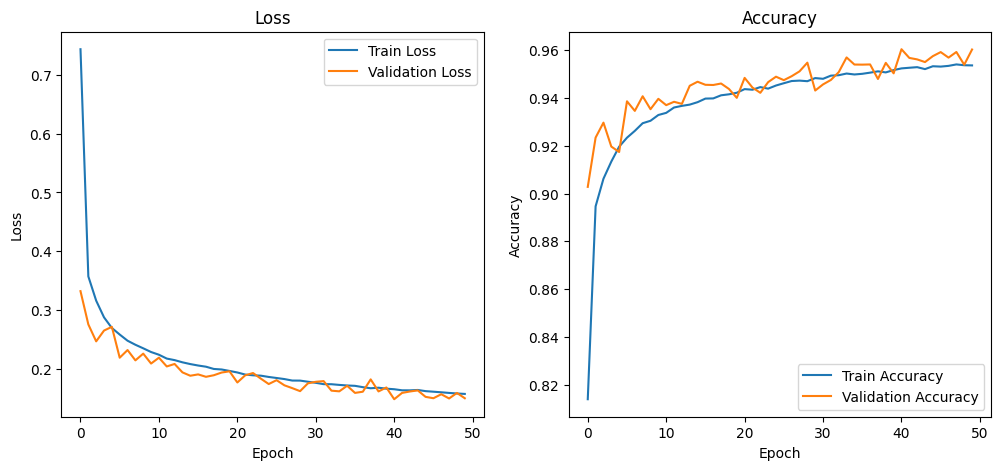

In [64]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
all_preds, all_labels = evaluate_model(model, test_dataloader, criterion, device=device)

Test Loss: 0.1508, Test Accuracy: 0.9590


In [70]:
cm = confusion_matrix(all_labels,all_preds)
recall = recall_score(all_labels,all_preds,average="weighted")
precision = precision_score(all_labels,all_preds,average="weighted")
f1 = f1_score(all_labels,all_preds,average="weighted")

print(f"recall score : {recall}")
print(f"precision score:{precision}")
print(f"f1 score :{f1}")

recall score : 0.960173031026253
precision score:0.9587516790512303
f1 score :0.9590715106117551


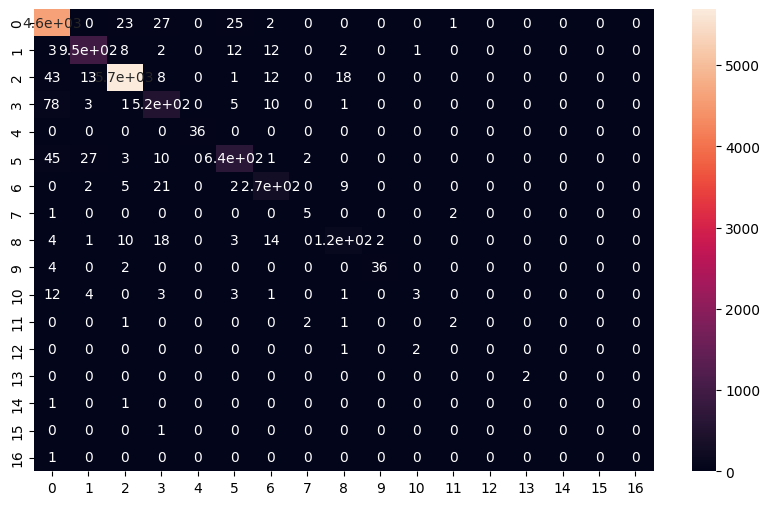

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm,annot=True,ax=ax)
plt.show()

In [73]:
# spot check
example = X_test[0]
example = torch.tensor(example, dtype=torch.float32).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(example)
    _, predicted = torch.max(output.data, 1)
    predicted_label = predicted.item()
    predicted_attack = attack_classes[predicted_label]
print(f"Predicted label: {predicted_label}, Predicted attack: {predicted_attack}, True label: {y_test[0]}, True attack: {attack_classes[y_test[0]]}")

Predicted label: 0, Predicted attack: Analysis, True label: 0, True attack: Analysis


In [74]:
# save the model
torch.save(model.state_dict(), 'best_attack_classifier_model.pth')